- **Project Title:** *LLM-as-a-Judge in Recommendations using BigQuery AI: From Profiles to Insights*
- **Problem Statement:** Most recommendation systems function as “black boxes,” surfacing items without offering context or transparency. This project uses BigQuery AI to automatically generate structured profiles of users and items, transform them into embeddings, and apply vector search to retrieve the most relevant matches. Each recommendation is then paired with an LLM-generated judgement, providing narrative reasoning that makes the system’s suggestions more interpretable.
- **Impact Statement:** This solution shows how organizations can build scalable, explainable recommendation engines directly within BigQuery without the need for specialized machine learning teams. By combining personalization with transparency, the approach improves user trust, helps businesses uncover actionable behavioral patterns, and extends seamlessly to domains such as e-commerce and media.
- **Project Highlights**
    - Developed adaptable, structured profiles for users and recipes using BigQuery AI, enabling easy customization for various business domains.
    - Demonstrated that a straightforward recommendation system powered by BigQuery AI can slightly outperform the ALS baseline, simplifying implementation and highlighting the potential of LLMs in recommendation workflows.
    - Created an interactive UI for users to browse personalized recommendations alongside clear, LLM-generated explanations.

# User & Recipe Profiles with BigQuery AI: From Embeddings to "Explainable" Recommendations


Inspired by the DoorDash blog post on [Profile Generation with LLMs](https://careersatdoordash.com/blog/doordash-profile-generation-llms-understanding-consumers-merchants-and-items/), this notebook showcases how to build user and recipe profiles leveraging BigQuery AI. It also outlines a workflow for generating potential recommendations, each paired with an "LLM-generated hypothesis" to provide narrative context for the suggestions.

This project addresses the challenges of **Approach 1 (The AI Architect)** and **Approach 2 (The Semantic Detective)** as described in the [Kaggle BigQuery Hackathon 2025](https://www.kaggle.com/competitions/bigquery-ai-hackathon/overview).

This notebook is structured as follows:

1. Data Sources
    - Datasets used (including sources and descriptions)
    - Preprocessing, splitting and uploading to BigQuery

2. (Approach 1) Recipe Profiles Generation
    - Profile schema design & prompt engineering
    - Using BigQuery AI to generate recipe profiles

3. (Approach 1) User Profiles Generation
    - Profile schema design & prompt engineering
    - Using BigQuery AI to generate user profiles

4. (Approach 2) Vector Search vs ALS
    - Using BigQuery AI to generate text embeddings
    - Vector search for recommendations
    - Comparing results with ALS baseline

5. (Approach 1) LLM-as-a-Judge as middle ground between Offline Metrics and A/B Testing
    - Pointwise LLM Judgement
    - Pairwise LLM Judgement

6. UI

7. Summary and Conclusions
    - Feedback on BigQuery AI features
    - User Survey on BigQuery AI features

## Setup & Project Creation

In [2]:
import ast
import seaborn as sns
from tqdm import tqdm
import os, json
import matplotlib.pyplot as plt
from IPython.display import display
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
import os, ast, numpy as np, pandas as pd
import random
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import subprocess
import bigframes.pandas as bpd
from google.cloud import bigquery

np.set_printoptions(suppress=True, precision=2)
pd.set_option("display.float_format", "{:.3f}".format)

load_dotenv()

True

In [3]:
os.environ['PROJECT_ID'] = input("Enter your Google Cloud Project ID: ")
PROJECT_ID = os.environ['PROJECT_ID']

subprocess.run(['gcloud', 'auth', 'login'])
subprocess.run(['gcloud', 'config', 'set', 'project', PROJECT_ID])
subprocess.run(['gcloud', 'auth', 'application-default', 'set-quota-project', PROJECT_ID])

bpd.options.bigquery.project = PROJECT_ID

random.seed(0)

CONNECTION_ID = 'us.kaggle-connection'
SCHEMA_NAME = 'deliverable'

VALID_INTERACTIONS = f"{PROJECT_ID}.{SCHEMA_NAME}.valid_interactions_windowed"
TRAIN_INTERACTIONS = f"{PROJECT_ID}.{SCHEMA_NAME}.train_interactions_windowed"
SUBSET_RECIPE_IDS = f"{PROJECT_ID}.{SCHEMA_NAME}.final_recipes"
SUBSET_USERS_IDS = f"{PROJECT_ID}.{SCHEMA_NAME}.final_users"

RECIPES_ALL = f"{PROJECT_ID}.{SCHEMA_NAME}.recipes"
OUT_DIM = 1024

RECIPES_PARSED = f'{SCHEMA_NAME}.recipes_parsed'
RECIPES_PROFILES_TABLE = f"{SCHEMA_NAME}.recipe_profiles"

USERS_PARSED = f'{SCHEMA_NAME}.users_parsed'
USERS_PROFILES_TABLE = f"{SCHEMA_NAME}.user_profiles"

VECTOR_SEARCH_RESULTS_TABLE = f"{SCHEMA_NAME}.vector_search_results"

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=lNJrinfwffGKwylOffOjsCB5q4MY0q&access_type=offline&code_challenge=I2ApFWM31fDy_3f3NNhKqF8X5CJMdQCUpIPlHDx_aa4&code_challenge_method=S256



Opening in existing browser session.



You are now logged in as [jeremy.matos@utec.edu.pe].
Your current project is [kaggle-bigquery-471522].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].

Credentials saved to file: [/home/tenken/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "kaggle-bigquery-471522" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


We use a [BigQuery client](https://cloud.google.com/bigquery/docs/datasets) to interact with the service in a more Pythonic way

In [4]:
client = bigquery.Client()

In [4]:
dataset = bigquery.Dataset(f"{client.project}.{SCHEMA_NAME}")
dataset.location = "US"

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except Exception as e:
    print(e)

409 POST https://bigquery.googleapis.com/bigquery/v2/projects/kaggle-bigquery-471522/datasets?prettyPrint=false: Already Exists: Dataset kaggle-bigquery-471522:deliverable


We create a Cloud Resource connection to interact with Vertex AI services

In [5]:
subprocess.run(['bq', 'mk', '--connection', '--location=us', '--connection_type=CLOUD_RESOURCE', f'{CONNECTION_ID.replace("us.", "")}'])

BigQuery error in mk operation: Already Exists: Connection
projects/352240171839/locations/us/connections/kaggle-connection


CompletedProcess(args=['bq', 'mk', '--connection', '--location=us', '--connection_type=CLOUD_RESOURCE', 'kaggle-connection'], returncode=2)

Following the tutorials on [GitHub](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/bigquery_embeddings_vector_search.ipynb) we create a remote connection to the Text Embedding model

In [6]:
client.query_and_wait(f"""
CREATE OR REPLACE MODEL `{SCHEMA_NAME}.text_embedding_model`
REMOTE WITH 
    CONNECTION `{CONNECTION_ID}`
    OPTIONS (ENDPOINT = 'gemini-embedding-001');
""")

# Data Sources

For the dataset selection, three considerations were made:
- The datasets are publicly available (in line with the competition guidelines)
- The dataset should align with the goal of addressing a real-world problem using solutions that integrate naturally with SQL workflows.
- The dataset needs to include unstructured, messy, and mixed data


We utilize the [FoodRecSysV1](https://www.kaggle.com/datasets/elisaxxygao/foodrecsysv1) dataset from Kaggle, which provides comprehensive user interactions with recipes; including ratings, comments, and rich recipe metadata. This dataset closely mirrors the real-world challenges encountered by platforms such as Cookpad, DoorDash, UberEats, and Rappi.

Other datasets like [MealRec](https://arxiv.org/abs/2205.12133) and [MealRec++](https://github.com/WUT-IDEA/MealRecPlus) were also considered (and we can apply the same methodology of this notebook), but for the sake of simplicity and ease to start, we opted for FoodRecSysV1.


In [7]:
import kagglehub

path = kagglehub.dataset_download("elisaxxygao/foodrecsysv1")

print("Path to dataset files:", path)

Path to dataset files: /home/tenken/.cache/kagglehub/datasets/elisaxxygao/foodrecsysv1/versions/1


In [8]:
os.listdir(path)

['raw-data_interaction.csv',
 'core-data-valid_rating.csv',
 'core-data_recipe.csv',
 'raw-data-images',
 'core-data-test_rating.csv',
 'core-data-train_rating.csv',
 'core-data-images',
 'raw-data_recipe.csv']

In [9]:
def clean_df(core: pd.DataFrame) -> pd.DataFrame:
    core['user_id'] = core['user_id'].astype(str)
    core['recipe_id'] = core['recipe_id'].astype(str)
    core['dateLastModified'] = core['dateLastModified'].apply(lambda v: v.replace('\n', ''))
    core['dateLastModified'] = pd.to_datetime(core['dateLastModified'], format='ISO8601')
    core['month'] = core['dateLastModified'].dt.month
    core['quarter'] = core['dateLastModified'].dt.quarter
    core['rating'] = core['rating'].astype(float)
    
    core = core.dropna(how='any').sort_values(by=['dateLastModified'], ascending=[True])
    return core

core_train_rating = pd.read_csv(f'{path}/core-data-train_rating.csv')
core_train_rating = clean_df(core_train_rating)
display('train', core_train_rating.dtypes, core_train_rating.describe())
print(f"{core_train_rating.shape=}")


core_test_rating = pd.read_csv(f'{path}/core-data-test_rating.csv')
core_test_rating = clean_df(core_test_rating)
display('test', core_test_rating.dtypes, core_test_rating.describe())


core_val_rating = pd.read_csv(f'{path}/core-data-valid_rating.csv')
core_val_rating = clean_df(core_val_rating)
display('val', core_val_rating.dtypes, core_val_rating.describe())

recipes = pd.read_csv('./data/food_recsys/raw-data_recipe.csv')
recipes['recipe_id'] = recipes['recipe_id'].astype(str)

'train'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,676946.000,676946,676946.000,676946.000
mean,4.469,2008-10-12 19:03:51.871918336,6.496,2.502
min,1.000,2000-02-08 12:09:11.987000,1.000,1.000
25%,4.000,2007-07-20 09:30:30.988250112,3.000,1.000
50%,5.000,2009-05-15 03:51:38.998499840,7.000,3.000
75%,5.000,2010-08-31 19:02:24.820499968,10.000,4.000
max,5.000,2011-10-14 17:43:08.433000,12.000,4.000
std,0.860,NaN,3.574,1.148


core_train_rating.shape=(676946, 6)


'test'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,283440.000,283440,283440.000,283440.000
mean,4.510,2015-02-09 01:26:51.432288512,6.310,2.438
min,1.000,2013-01-31 22:55:07.660000,1.000,1.000
25%,4.000,2013-11-26 10:55:44.029000192,3.000,1.000
50%,5.000,2014-11-15 07:59:59.511500032,6.000,2.000
75%,5.000,2016-03-13 10:05:13.634749952,10.000,4.000
max,5.000,2018-03-15 03:09:12.853000,12.000,4.000
std,0.851,NaN,3.595,1.161


'val'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,133459.000,133459,133459.000,133459.000
mean,4.506,2012-05-23 09:30:25.575911936,6.870,2.643
min,1.000,2011-10-14 17:46:56.443000,1.000,1.000
25%,4.000,2012-01-16 12:26:58.273499904,3.000,1.000
50%,5.000,2012-05-11 17:51:50.223000064,7.000,3.000
75%,5.000,2012-09-24 14:10:02.375000064,11.000,4.000
max,5.000,2013-01-31 22:23:27.613000,12.000,4.000
std,0.830,NaN,3.978,1.245


We select a focused subset of the dataset, prioritizing the most engaged users and popular recipes to ensure our experiments are both manageable and representative. The filtered training set covers 24 weeks (about 6 months), while the filtered validation set spans 4 weeks (1 month) and includes only positive ratings (≥ 3 stars). To guarantee sufficient data for generating and evaluating profiles, we exclude users with fewer than 5 interactions in either set.

In [10]:
PREV_WEEKS = 24
POST_WEEKS = 4
MIN_INTERACTIONS_TRAIN = 5
MIN_INTERACTIONS_VAL = 5
print(f"Using last {PREV_WEEKS} weeks of training data to predict next {POST_WEEKS} weeks of ratings, with at least {MIN_INTERACTIONS_TRAIN} interactions in training and {MIN_INTERACTIONS_VAL} interactions in validation for each user")

min_date_val = core_train_rating['dateLastModified'].max() - pd.Timedelta(weeks=PREV_WEEKS)
max_date_val = core_val_rating['dateLastModified'].min() + pd.Timedelta(weeks=POST_WEEKS)

print(f"From {min_date_val} to {max_date_val}")

Using last 24 weeks of training data to predict next 4 weeks of ratings, with at least 5 interactions in training and 5 interactions in validation for each user
From 2011-04-29 17:43:08.433000 to 2011-11-11 17:46:56.443000


In [11]:
# Use training data of last N weeks only
core_train_rating = core_train_rating.loc[
    lambda df: df['dateLastModified'] >= min_date_val
]

# Reduce val predictions to next POST_WEEKS only
core_val_rating = core_val_rating.loc[
    lambda df: (df['dateLastModified'] <= max_date_val) & (df['rating'] >= 3)
]

# Find common users and recipes first
common_users = set(core_train_rating['user_id']).intersection(set(core_val_rating['user_id']))
common_recipes = set(core_train_rating['recipe_id']).intersection(set(core_val_rating['recipe_id']))
print(f"{len(common_users)=}, {len(common_recipes)=}")

# Filter both datasets to only include common users and recipes
train_users = core_train_rating[
    core_train_rating['user_id'].isin(common_users) & 
    core_train_rating['recipe_id'].isin(common_recipes)
]
val_users = core_val_rating[
    core_val_rating['user_id'].isin(common_users) & 
    core_val_rating['recipe_id'].isin(common_recipes)
]

common_users = set(train_users['user_id']).intersection(set(val_users['user_id']))
common_recipes = set(train_users['recipe_id']).intersection(set(val_users['recipe_id']))
print(f"{len(common_users)=}, {len(common_recipes)=}")

# Now filter by minimum interactions AFTER filtering by common users/recipes
train_user_counts = train_users['user_id'].value_counts()
val_user_counts = val_users['user_id'].value_counts()
train_recipe_counts = train_users['recipe_id'].value_counts()
val_recipe_counts = val_users['recipe_id'].value_counts()

# Users and recipes with at least MIN_INTERACTIONS interactions in FINAL filtered datasets
users_min_it_train = set(train_user_counts[train_user_counts >= MIN_INTERACTIONS_TRAIN].index)
users_min_it_val = set(val_user_counts[val_user_counts >= MIN_INTERACTIONS_VAL].index)

# Final common users and recipes with minimum interactions
final_users = users_min_it_train.intersection(users_min_it_val)

# Apply final filter
train_users = train_users[train_users['user_id'].isin(final_users)]
val_users = val_users[(val_users['user_id'].isin(final_users))]
final_recipes = set(train_users['recipe_id'].values).union(set(val_users['recipe_id'].values))

# Use final recipes for all recipe datasets
train_recipes = val_recipes = recipes[recipes['recipe_id'].isin(final_recipes)]


print(f"Final datasets: {len(train_users)} train interactions, {len(val_users)} val interactions")

# Verify minimum interactions constraint
print(f"Min interactions per user in train: {train_users['user_id'].value_counts().min()}")
print(f"Min interactions per user in val: {val_users['user_id'].value_counts().min()}")

display('train_users', train_users['user_id'].value_counts().sort_values(ascending=False))
display('val_users', val_users['user_id'].value_counts().sort_values(ascending=False))
print(f"Users: {len(final_users)}, Recipes: {len(final_recipes)}")


len(common_users)=3729, len(common_recipes)=3764
len(common_users)=2942, len(common_recipes)=2628
Final datasets: 2730 train interactions, 1066 val interactions
Min interactions per user in train: 5
Min interactions per user in val: 5


'train_users'

user_id
1037986    176
2043209    105
2448319    104
2702518     80
2995814     70
          ... 
2233245      5
6392312      5
3500863      5
2524829      5
4053273      5
Name: count, Length: 131, dtype: int64

'val_users'

user_id
1037986    31
2995814    29
2043209    29
2448319    24
6067445    21
           ..
3047421     5
484578      5
5017867     5
301943      5
1054570     5
Name: count, Length: 131, dtype: int64

Users: 131, Recipes: 2048


We'll finally use a total of 131 users and 2048 recipes, a size that balances data volume and execution time for demonstration purposes.


In [ ]:
# Upload tables to BigQuery
train_users.to_gbq(TRAIN_INTERACTIONS, if_exists='replace')
val_users.to_gbq(VALID_INTERACTIONS, if_exists='replace')
train_recipes[['recipe_id']].to_gbq(SUBSET_RECIPE_IDS, if_exists='replace')
pd.DataFrame({'user_id': list(final_users)}).to_gbq(SUBSET_USERS_IDS, if_exists='replace')

/tmp/ipykernel_5601/349922751.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  train_users.to_gbq(TRAIN_INTERACTIONS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]
/tmp/ipykernel_5601/349922751.py:4: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  val_users.to_gbq(VALID_INTERACTIONS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]
/tmp/ipykernel_5601/349922751.py:5: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  train_recipes[['recipe_id']].to_gbq(SUBSET_RECIPE_IDS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9

In [13]:
recipes.to_gbq(RECIPES_ALL, if_exists='replace')

/tmp/ipykernel_5601/1013056983.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  recipes.to_gbq(RECIPES_ALL, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 7219.11it/s]


Next, we'll generate profiles following the approach described in the [Spotify blog](https://research.atspotify.com/2025/9/profile-aware-llm-as-a-judge-for-podcasts-a-better-middle-ground-between). As highlighted in the blog, this method primarily simplifies prompt complexity and preserves alignment. Before proceeding, let's define some utility functions:

In [20]:
def schema_to_prompt_with_descriptions(model_class) -> str:
    prompt = ""
    for k, v in model_class.model_json_schema()['properties'].items():
        desc = v.get('description', '')
        prompt += f" {k} ({desc}) "
    return f"[ {prompt} ]"

# Recipe Profiles Generation

We start cleaning and parsing some columns to make them suitable and more understandable for the LLM.

In [15]:
def prep_ingredients(text: str) -> str:
    if pd.isna(text): return ""
    return "\n".join([f"- {v}" for v in str(text).split('^')])


def prep_directions(text: str) -> str:
    if pd.isna(text): return ""
    s = str(text)
    # Some rows look like dict-strings with 'directions' inside; just fall back to raw text
    # Optionally, try to parse if it starts with "{"
    if s.strip().startswith("{"):
        try:
            d = ast.literal_eval(s)
            # common keys: 'directions' (string) or list
            v = d.get('directions', "")
            v = str(v).split('\n')
            v = [x.strip() for x in v if len(x.strip()) > 0]
            v = [f". {x}" if x and x[0].isupper() else x for x in v]

            return " ".join(v).strip(".").replace(" . ", ". ").replace("..", ".").strip()
        except Exception:
            return s.lower()
    return s.lower()


In [16]:
df_recipes = bpd.read_gbq(f"""
SELECT * FROM `{SUBSET_RECIPE_IDS}`
LEFT JOIN `{RECIPES_ALL}` USING(recipe_id)
""")

# Convert to pandas DataFrame to use custom functions, then back to BigFrames
df_recipes_pandas = df_recipes.to_pandas()

We create `parsed_ingredients` and `parsed_recipe` columns to then insert it into the prompt for profile generation.

In [17]:
nutrition_values = []
for idx, row in tqdm(df_recipes_pandas.iterrows(), total=len(df_recipes_pandas)):
    nutritions_dict = ast.literal_eval(row['nutritions'])
    
    row_info = {'recipe_id': row['recipe_id']}
    nutritions_info = {}
    for k in ['niacin', 'sugars', 'sodium', 'carbohydrates', 'vitaminB6', 'calories', 'thiamin', 'fat', 'folate', 'caloriesFromFat', 'calcium', 'fiber', 'magnesium', 'iron', 'cholesterol', 'protein', 'vitaminA', 'potassium', 'saturatedFat', 'vitaminC']:
        if k in nutritions_dict:
            nutritions_info[k] = nutritions_dict[k].get('percentDailyValue', -1)
            if nutritions_info[k] is not None:
                v = str(nutritions_info[k]).strip()
                if v == '< 1':
                    nutritions_info[k] = 0.0
                # if v == '-':
                #     nutritions_info[k] = -1
                
                try:
                    nutritions_info[k] = f"{nutritions_info[k]} percent"
                except Exception:
                    pass
    
    row_info['percent_daily_values'] = "\n".join([f"{k}: {v}" for k, v in nutritions_info.items()])
    nutrition_values.append(row_info)

nutrition_df = pd.DataFrame(nutrition_values).fillna(-2)

df_recipes_pandas['parsed_ingredients'] = df_recipes_pandas['ingredients'].apply(prep_ingredients)
df_recipes_pandas['parsed_recipe'] = df_recipes_pandas['cooking_directions'].apply(prep_directions)
df_recipes_pandas = df_recipes_pandas.merge(nutrition_df, how='left', on='recipe_id')
df_recipes_pandas['title'] = df_recipes_pandas['recipe_name']
df_recipes = bpd.DataFrame(df_recipes_pandas)

# Upload the new table in BigQuery
df_recipes.to_gbq(
    destination_table=f"{PROJECT_ID}.{RECIPES_PARSED}",
    if_exists='replace',
)

100%|██████████| 2048/2048 [00:01<00:00, 1874.92it/s]


'kaggle-bigquery-471522.deliverable.recipes_parsed'

Following the [DoorDash blog](https://careersatdoordash.com/blog/doordash-profile-generation-llms-understanding-consumers-merchants-and-items/) we define the structure and attributes of the "Recipe Profile" (item profiles). In this case we use a Pydantic model to define the schema, which then parsed as part of the prompt using the function `schema_to_prompt_with_descriptions`.

In [18]:
class RecipeProfile(BaseModel):
    food_type: str = Field(description="Type of food, e.g., dessert, main course, appetizer")
    cuisine_type: str = Field(description="Cuisine type, e.g., Italian, Chinese, Mexican, American")
    dietary_preferences: List[str] = Field(description="Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free")
    flavor_profile: List[str] = Field(description="Flavor profile, e.g., spicy, sweet, savory")
    serving_daypart: List[str] = Field(description="Suitable dayparts, e.g., breakfast, lunch, dinner")
    notes: str = Field(description="Short rationale summarizing the recipe profile")
    target_audience: str = Field(description="Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preferences. Helps recommendation systems match recipes to appropriate user profiles.")
    justification: str = Field(description="Detailed explanation of how the profile was determined Describe why the food type, cuisine type, dietary preferences, flavor profile, and serving daypart were chosen based on the ingredients and cooking directions. Is not allowed to use quotes or complex punctuation in this field.")


This schema could be enhanced by using more restrictive field types, such as `Enums` or `Literal` for categorical attributes. This would make it easier to apply business logic based on the extracted category metadata generated by the LLM in future iterations. 

Then, we define the prompt template for recipe profile generation, including explicit instructions to avoid issues with quotes, punctuation, and special characters - challenges encountered when using `AI.GENERATE` with limited output tokens.

In [19]:
recipe_profile_prompt = f"""Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: {schema_to_prompt_with_descriptions(RecipeProfile)}. IMPORTANT: Do not use quotation marks or complex punctuation in your response. Use simple words and avoid any quotes, apostrophes, or special characters."""

print(recipe_profile_prompt)

Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: [  food_type (Type of food, e.g., dessert, main course, appetizer)  cuisine_type (Cuisine type, e.g., Italian, Chinese, Mexican, American)  dietary_preferences (Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free)  flavor_profile (Flavor profile, e.g., spicy, sweet, savory)  serving_daypart (Suitable dayparts, e.g., breakfast, lunch, dinner)  notes (Short rationale summarizing the recipe profile)  target_audience (Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preferences. Helps recommendation systems match recipes to appropriate user profiles.)  justification (Detailed explanation of how the profile was determined Describe why the food type, cuisine type, dietary preferences, fla

We set the `temperature` parameter to **1.0** to promote creativity and encourage the model to explore a wide range of recipe characteristics during profile generation. The `maxOutputTokens` is set to `2048` to stay within the [Gemini Embedding Model's input token limit](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings). Additionally, we allocate up to `1024` thinking tokens to leverage the model’s reasoning abilities, aiming for a balance between accuracy and latency. Finally, we choose `gemini-2.5-flash` model for speed and cost efficiency.

<!-- https://developers.googleblog.com/en/gemini-embedding-available-gemini-api/ -->

In [20]:
recipe_profile_generation_query = f"""
WITH ai_responses AS (
  SELECT 
    s.recipe_id, 
    s.title, 
    s.ingredients, 
    s.cooking_directions, 
    s.nutritions, 
    s.reviews, 
    s.parsed_ingredients, 
    s.parsed_recipe,
    AI.GENERATE(('{recipe_profile_prompt}', s.parsed_ingredients, s.parsed_recipe, s.percent_daily_values),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-flash',
        model_params => JSON '{{"generationConfig":{{"temperature": 1.0, "maxOutputTokens": 2048, "thinking_config": {{"thinking_budget": 1024}} }} }}',
        output_schema => 'food_type STRING, cuisine_type STRING, dietary_preferences ARRAY<STRING>, flavor_profile ARRAY<STRING>, serving_daypart ARRAY<STRING>, notes STRING, target_audience STRING, justification STRING'
    ) AS ai_result
  FROM (SELECT * FROM `{RECIPES_PARSED}`) s
)
SELECT 
  *,
  ai_result.full_response AS recipe_profile,
  JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS recipe_profile_text
FROM ai_responses
"""

print(recipe_profile_generation_query)


WITH ai_responses AS (
  SELECT 
    s.recipe_id, 
    s.title, 
    s.ingredients, 
    s.cooking_directions, 
    s.nutritions, 
    s.reviews, 
    s.parsed_ingredients, 
    s.parsed_recipe,
    AI.GENERATE(('Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: [  food_type (Type of food, e.g., dessert, main course, appetizer)  cuisine_type (Cuisine type, e.g., Italian, Chinese, Mexican, American)  dietary_preferences (Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free)  flavor_profile (Flavor profile, e.g., spicy, sweet, savory)  serving_daypart (Suitable dayparts, e.g., breakfast, lunch, dinner)  notes (Short rationale summarizing the recipe profile)  target_audience (Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preference

With this prompt, we can execute the SQL query using the BigQuery client. We encountered some challenges when specifying the prompt directly within the SQL query, such as issues with quotation marks (to highlight words), punctuation and line breaks, which are common in longer prompts. To mitigate these problems, we define the prompt as a single paragraph. It would be helpful if there were a way to use multi-line strings directly in SQL queries. Finally we saved the results in a new table.

In [21]:
recipe_rows = client.query_and_wait(recipe_profile_generation_query)
df_recipes_profiles = recipe_rows.to_dataframe()

response = json.loads(df_recipes_profiles['recipe_profile'].iloc[0])
r_profile = json.loads(response['candidates'][0]['content']['parts'][0]['text'])
                      
print(json.dumps(response, indent=2))
print(json.dumps(json.loads(df_recipes_profiles['recipe_profile_text'].iloc[0]), indent=2))
print(f"{r_profile=}")

df_recipes_profiles.to_gbq(
    destination_table=f"{PROJECT_ID}.{RECIPES_PROFILES_TABLE}",
    if_exists='replace',
)

{
  "candidates": [
    {
      "avg_logprobs": -0.9889099980743838,
      "content": {
        "parts": [
          {
            "text": "{\n  \"cuisine_type\": \"Mexican\",\n  \"dietary_preferences\": [\n    \"vegetarian\"\n  ],\n  \"flavor_profile\": [\n    \"sweet\",\n    \"savory\",\n    \"tangy\"\n  ],\n  \"food_type\": \"main course\",\n  \"justification\": \"The food type is main course because the recipe involves substantial ingredients like sweet potatoes black beans and cheese enclosed in tortillas cooked and served in wedges making it a filling meal. The cuisine type is Mexican due to the prominent use of tortillas black beans and salsa which are staples in Mexican and Tex-Mex cooking along with the quesadilla preparation method. Dietary preferences are vegetarian because the ingredients include sweet potatoes black beans and tortillas which are plant-based along with cheddar cheese which is dairy but no meat or poultry is present. The flavor profile is sweet from the swee

/tmp/ipykernel_5601/584357236.py:11: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_recipes_profiles.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]


# User Profiles Generation

In this section, we generate user profiles based on their historical interactions with recipes. The interactions include ratings, comments, and timestamps that we provide in the prompt.

In [22]:
df_recipe_metadata = client.query_and_wait(f"""SELECT recipe_id, title, parsed_ingredients, parsed_recipe, recipe_profile_text, reviews FROM `{RECIPES_PROFILES_TABLE}`""").to_dataframe()

reviews = []
for idx, row in tqdm(df_recipe_metadata.iterrows(), total=len(df_recipe_metadata)):
    recipe_id = row['recipe_id']
    interactions_dict = ast.literal_eval(row['reviews'])
    for k, v in interactions_dict.items():
        reviews.append({
            'recipe_id': recipe_id,
            'user_id': str(k),
            **v
        })
reviews_df = pd.DataFrame(reviews)
reviews_df.columns = reviews_df.columns.str.lower()
reviews_df['datelastmodified'] = pd.to_datetime(reviews_df['datelastmodified'], format='mixed')

100%|██████████| 2048/2048 [01:13<00:00, 27.90it/s] 


In [5]:
SUBSET_COLS = 'user_id, recipe_id, rating, datelastmodified'

In [ ]:
df_train_users = client.query_and_wait(f"""SELECT {SUBSET_COLS} FROM `{TRAIN_INTERACTIONS}`""").to_dataframe()
df_valid_users = client.query_and_wait(f"""SELECT {SUBSET_COLS} FROM `{VALID_INTERACTIONS}`""").to_dataframe()

We drop `user_id`s that are not present in both train and validation sets to ensure consistency when generating and evaluating recommendation between Vector Search and ALS.

In [ ]:
# Drop users in valid not present in train_set
FINAL_USERS = set(df_train_users['user_id'].unique()).intersection(set(df_valid_users['user_id'].unique()))

# Adding user comments from reviews
df_users_history = df_train_users[df_train_users['user_id'].isin(FINAL_USERS)].reset_index(drop=True)
df_users_history['datelastmodified'] = pd.to_datetime(df_users_history['datelastmodified'])
df_users_history = df_users_history.merge(
    reviews_df[['user_id', 'recipe_id', 'datelastmodified', 'text']], how='left', 
    on=['user_id', 'recipe_id', 'datelastmodified'],
    validate='one_to_one'
).rename(columns={'text': 'user_comment'})

df_valid_users = df_valid_users[df_valid_users['user_id'].isin(FINAL_USERS)].reset_index(drop=True)


In [ ]:
print(f"Final users: {len(FINAL_USERS)}")

print(df_users_history.describe())
print(df_valid_users.describe())

df_users_to_profile = df_valid_users.groupby('user_id').agg({'recipe_id': 'unique'}).reset_index().rename(columns={
    'recipe_id': 'rec_gt'
})  # , 'datelastmodified'

Final users: 131
        rating            datelastmodified
count 2730.000                        2730
mean     4.496  2011-07-27 01:47:37.662131
min      1.000  2011-04-29 18:43:20.453000
25%      4.000  2011-06-14 12:31:13.382750
50%      5.000  2011-07-29 09:15:59.395000
75%      5.000  2011-09-07 19:15:58.460500
max      5.000  2011-10-14 17:24:08.330000
std      0.757                         NaN
        rating            datelastmodified
count 1066.000                        1066
mean     4.559  2011-10-29 01:36:00.828909
min      3.000  2011-10-14 20:03:19.147000
25%      4.000  2011-10-22 12:28:31.182000
50%      5.000  2011-10-28 18:52:05.890000
75%      5.000  2011-11-05 06:16:04.777250
max      5.000  2011-11-11 17:43:12.483000
std      0.629                         NaN


To generate user profiles, we leverage the large context window of Gemini models by including each user's historical interactions, such as ratings and comments, directly in the prompt. We cap the history at 25 interactions (we could tune this argument) to keep the context manageable and ensure faster response times. The interactions are formatted as a bulleted list to help the LLM interpret the information more effectively.

In [ ]:
def get_user_history(user_id: int, n: int = 25, k_min: int = 5) -> list:
    """Get the top-n most recent recipes the user has interacted with."""
    user_history = df_users_history[df_users_history['user_id'] == user_id]
    user_history = user_history.sort_values(by='datelastmodified', ascending=False).head(n)
    assert len(user_history) >= k_min, f"User {user_id} has less than {k_min} interactions in the training set."

    user_history['date'] = user_history['datelastmodified'].dt.strftime('%Y-%m-%d')

    return user_history[['recipe_id', 'rating', 'date', 'user_comment']].to_dict('records')


def format_user_history(user_history: list[dict]) -> str:
    """Format the user history as a bulleted list."""

    user_info = ""
    avg_rating = 0
    for entry in user_history:
        recipe_metadata = df_recipe_metadata.loc[lambda df: df['recipe_id'] == entry['recipe_id'], ['recipe_id', 'title', 'parsed_ingredients', 'parsed_recipe', 'recipe_profile_text']].reset_index(drop=True).iloc[0]
        avg_rating += entry['rating']

        user_info += (
            f"\n>>> Recipe Title: {recipe_metadata['title']}\n"
            f">>> User Rating: {entry['rating']}\n"
            f">>> Date of Interaction: {entry['date']}\n\n"
            f">>> User Comment: {entry['user_comment']}\n\n"
            # TODO: Those columns are missing
            # f"Recipe Average Rating: {row['aver_rate']}\n"
            f">>> Ingredients:\n{recipe_metadata['parsed_ingredients']}\n\n"
            f">>> Cooking Directions:\n{recipe_metadata['parsed_recipe']}\n"
        )
        user_info += "--------------------------------------------\n"
    avg_rating /= len(user_history)
    user_info = f"The user has rated {len(user_history)} recipes, with an average rating of {avg_rating:.2f}.\n{user_info}"
    user_info = "########################################### USER HISTORY START ###########################################\n" + user_info
    user_info += "########################################### USER HISTORY END ###########################################\n"
    
    return user_info

'kaggle-bigquery-471522.deliverable.users_parsed'

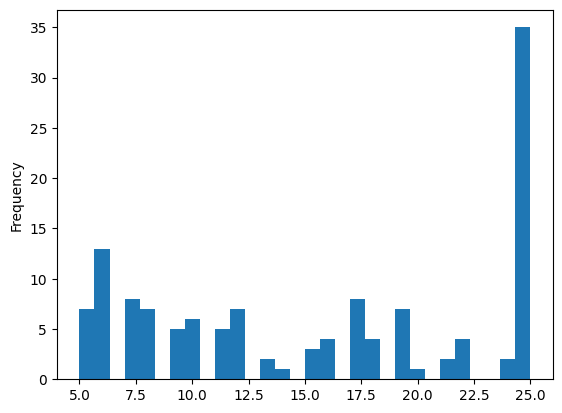

In [26]:
df_users_to_profile['user_history'] = df_users_to_profile['user_id'].apply(get_user_history)
df_users_to_profile['n_history'] = df_users_to_profile['user_history'].apply(len)

df_users_to_profile['n_history'].plot.hist(bins=30)

# print(format_user_history(df_users_to_profile['user_history'].iloc[0]))
df_users_to_profile['history_string'] = df_users_to_profile['user_history'].apply(format_user_history)

bpd.DataFrame(df_users_to_profile).to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PARSED}",
    if_exists='replace',
)

As in the recipe profiles, we define a Pydantic model, that it can be improved and adapted to the specific business case.

In [27]:
class UserProfile(BaseModel):
    liked_cuisines: List[str] = Field(description="List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings")
    cuisine_preference: str = Field(description="Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American)")
    dietary_preference: str = Field(description="Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions)")

    food_preferences: List[str] = Field(description="Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grilled meats)")
    top_cuisine_choices: List[str] = Field(description="Specific regional or ethnic cuisines the user frequently rates highly (e.g., Thai, Southern BBQ, French pastry)")
    dietary_preferences: List[str] = Field(description="Dietary restrictions, health considerations, or eating patterns (e.g., gluten-free, plant-based, high-protein, dairy-free)")
    flavor_preferences: List[str] = Field(description="Dominant taste profiles and flavor characteristics the user seeks (e.g., bold and spicy, mild and creamy, tangy and citrusy)")
    daypart_preferences: List[str] = Field(description="Preferred times of day for different meal types based on rating patterns (e.g., hearty breakfast, light lunch, elaborate dinner)")
    lifestyle_tags: List[str] = Field(description="Behavioral patterns and cooking style indicators inferred from recipe choices (e.g., quick meals, entertainer, health-conscious, experimental cook)")
    convenience_preference: str = Field(description="Preference for recipe complexity (e.g., quick and easy, gourmet elaborate)")
    diversity_openness: str = Field(description="Willingness to try new cuisines (e.g., adventurous, selective, traditionalist, not defined)")

    notes: str = Field(description="Brief summary explaining the users overall food personality and any notable patterns in their preferences")
    justification: str = Field(description="Detailed explanation of how the profile was determined based on the users interaction history and ratings. Describe why the liked cuisines, cuisine preference, dietary preference, food preferences, cuisine preferences, dietary preferences, flavor preferences, daypart preferences, and lifestyle tags were chosen. Is not allowed to use quotes or complex punctuation in this field. Keep it between 100 and 200 words not more.")
    user_story: str = Field(description="Predictive narrative about the user s culinary evolution and potential future preferences. Describes their food journey, emerging patterns, and likely directions for taste exploration. Written to help predict what they might enjoy next based on their current trajectory and evolving palate.")
    future_preferences: str = Field(description="Speculative insights into the types of recipes and cuisines the user may be inclined to explore in the future. Based on their current preferences, suggest new food categories, cooking styles, or dietary trends they might be open to trying next. This helps in anticipating their evolving culinary interests.")


In [28]:
user_profile_prompt = f"""Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: {schema_to_prompt_with_descriptions(UserProfile)}. Each fill of the structured output doesnt need to take more than 200 words keep it in mind. IMPORTANT: Do not use quotation marks or complex punctuation in your response. Use simple words and avoid any quotes, apostrophes, or special characters. Use the following interaction history as reference:"""

print(user_profile_prompt)

Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grilled meats))  top_cuisine_choices (Specific regional or ethnic cuisines the user frequently rates highly (e.g.

We use the same parameter settings as in the recipe profiles generation.

In [29]:
user_profile_generation_query = f"""
WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('{user_profile_prompt}', s.history_string),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-flash',
        model_params => JSON '{{"generationConfig":{{"temperature": 1.0, "maxOutputTokens": 2048, "thinking_config": {{"thinking_budget": 1024}} }} }}',
        output_schema => 'liked_cuisines ARRAY<STRING>, cuisine_preference STRING, dietary_preference STRING, food_preferences ARRAY<STRING>, top_cuisine_choices ARRAY<STRING>, dietary_preferences ARRAY<STRING>, flavor_preferences ARRAY<STRING>, daypart_preferences ARRAY<STRING>, lifestyle_tags ARRAY<STRING>, convenience_preference STRING, diversity_openness STRING, notes STRING, justification STRING, user_story STRING, future_preferences STRING'
    ) AS ai_result
  FROM (SELECT * FROM `{USERS_PARSED}`) s
)
SELECT 
  *,
  ai_result.full_response AS user_profile,
  JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS user_profile_text
FROM ai_responses
"""

print(user_profile_generation_query)


WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grille

In [30]:
print(user_profile_generation_query)
user_rows = client.query_and_wait(user_profile_generation_query)
df_users_profiles = user_rows.to_dataframe()

print(json.dumps(json.loads(df_users_profiles['user_profile_text'].iloc[0]), indent=2))

df_users_profiles.to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PROFILES_TABLE}",
    if_exists='replace',
)


WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grille

/tmp/ipykernel_5601/2933704288.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_users_profiles.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8004.40it/s]


# Vector Search vs ALS


We begin creating the text embeddings for both user and recipe **profiles**, as follow:

In [31]:
client.query_and_wait(f"""
ALTER TABLE `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
ADD COLUMN text_embedding ARRAY<FLOAT64>
""")

client.query_and_wait(f"""
UPDATE `{PROJECT_ID}.{USERS_PROFILES_TABLE}` AS t
SET t.text_embedding = s.ml_generate_embedding_result
FROM (
  SELECT
    user_id,
    ml_generate_embedding_result
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `{SCHEMA_NAME}.text_embedding_model`,
      (
        SELECT
          user_id,
          user_profile_text AS content
        FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
      ),
      STRUCT(TRUE AS flatten_json_output, {OUT_DIM} AS OUTPUT_DIMENSIONALITY, 'RETRIEVAL_QUERY' AS task_type)
    )
) AS s
WHERE t.user_id = s.user_id
""")

In [32]:
client.query_and_wait(f"""
ALTER TABLE `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
ADD COLUMN text_embedding ARRAY<FLOAT64>
""")

# Create Vector Embeddings for the recipe profiles
client.query_and_wait(f"""
UPDATE `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}` AS t
SET t.text_embedding = s.ml_generate_embedding_result
FROM (
  SELECT
    recipe_id,
    ml_generate_embedding_result
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `{SCHEMA_NAME}.text_embedding_model`,
      (
        SELECT
          recipe_id,
          recipe_profile_text AS content
        FROM `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
      ),
      STRUCT(TRUE AS flatten_json_output, {OUT_DIM} AS OUTPUT_DIMENSIONALITY, 'RETRIEVAL_DOCUMENT' AS task_type)
    )
) AS s
WHERE t.recipe_id = s.recipe_id
""")

We also combine some columns to facilitate model evaluation later on.

In [33]:
# Parse column to exclude recipe_history from vector search
df = client.query_and_wait(f"""
SELECT * FROM `{PROJECT_ID}.{USERS_PARSED}`
""").to_dataframe()

df['recipes_to_exclude'] = df['user_history'].apply(lambda x: [entry['recipe_id'] for entry in x])

# Update entire table with the new column
df.to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PARSED}",
    if_exists='replace',
)

# Add new column to user profiles table via left join
client.query_and_wait(f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{USERS_PROFILES_TABLE}` AS
SELECT u.*, p.recipes_to_exclude, p.rec_gt
FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}` u
LEFT JOIN `{PROJECT_ID}.{USERS_PARSED}` p USING(user_id)
""")

/tmp/ipykernel_5601/2211945682.py:9: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8256.50it/s]


In [1]:
TOP_K = 20
N_NEIGHBORS = 20
PLOT = True

We observed that the `gemini-embedding-001` model returns empty embeddings (arrays of zeros) for some recipes. The cause of this behavior is unclear for us, but to prevent downstream issues, we exclude these recipes from the recommendation pipeline (retrieval, ALS and evaluation).

In [6]:
user_queries = client.query_and_wait(f"""
SELECT user_id, recipes_to_exclude, text_embedding FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
""").to_dataframe()
user_queries['len'] = user_queries['text_embedding'].apply(len)
print(f"{user_queries['len'].value_counts()=}")

df_recipe_profiles = client.query_and_wait(f"""
  SELECT recipe_id, recipe_profile_text, text_embedding FROM `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
""").to_dataframe()
df_recipe_profiles['len'] = df_recipe_profiles['text_embedding'].apply(len)
print(f"{df_recipe_profiles['len'].value_counts()=}")

excluded_recipes = df_recipe_profiles[df_recipe_profiles['len'] == 0]['recipe_id'].tolist()
print(f"Excluding {len(excluded_recipes)} recipes with empty embeddings")

user_queries['len'].value_counts()=len
1024    131
Name: count, dtype: int64
df_recipe_profiles['len'].value_counts()=len
1024    1359
0        689
Name: count, dtype: int64
Excluding 689 recipes with empty embeddings


## Vector Search powered by BigQuery AI and Gemini Embeddings

After the time intensive preprocessing steps of building profiles and generating embeddings, we can run a vector search to match user profiles with recipe profiles. In `query_vector_search`, we compare only embeddings with nonzero length, as noted earlier. This semantic search helps with cold start by recommending new, unrated recipes based on their content and their similarity to the user’s profile.

In [7]:
query_vector_search = f"""
SELECT * FROM
VECTOR_SEARCH(
    (
        SELECT
        title, recipe_id, recipe_profile_text, parsed_ingredients, parsed_recipe, text_embedding
        FROM `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
        WHERE text_embedding IS NOT NULL 
        AND ARRAY_LENGTH(text_embedding) > 0
    ),
    'text_embedding',
    (
        SELECT
        text_embedding, n_history, user_id, rec_gt, recipes_to_exclude, user_profile_text
        FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
        WHERE text_embedding IS NOT NULL 
        AND ARRAY_LENGTH(text_embedding) > 0
    ),
    'text_embedding',
    top_k => {TOP_K},
    distance_type => 'COSINE'
)
"""
print(query_vector_search)


SELECT * FROM
VECTOR_SEARCH(
    (
        SELECT
        title, recipe_id, recipe_profile_text, parsed_ingredients, parsed_recipe, text_embedding
        FROM `kaggle-bigquery-471522.deliverable.recipe_profiles`
        WHERE text_embedding IS NOT NULL 
        AND ARRAY_LENGTH(text_embedding) > 0
    ),
    'text_embedding',
    (
        SELECT
        text_embedding, n_history, user_id, rec_gt, recipes_to_exclude, user_profile_text
        FROM `kaggle-bigquery-471522.deliverable.user_profiles`
        WHERE text_embedding IS NOT NULL 
        AND ARRAY_LENGTH(text_embedding) > 0
    ),
    'text_embedding',
    top_k => 20,
    distance_type => 'COSINE'
)



In [8]:
matches_vs = client.query_and_wait(query_vector_search).to_dataframe()

df_query = pd.json_normalize(matches_vs["query"]).rename(columns={
    'text_embedding': 'user_text_embedding',
})
df_base = pd.json_normalize(matches_vs["base"]).rename(columns={
    'text_embedding': 'recipe_text_embedding',
})
matches_vs = pd.concat([matches_vs.drop(["query","base"], axis=1), df_query, df_base], axis=1)

display(matches_vs.head(5))

,distance,user_text_embedding,n_history,user_id,rec_gt,recipes_to_exclude,user_profile_text,title,recipe_id,recipe_profile_text,parsed_ingredients,parsed_recipe,recipe_text_embedding
0,0.185,"[0.02171381749212742, 0.0064751687459647655, 0...",25,2100575,"[6989, 84109, 20808, 24740, 9926, 179582, 21387]","[70343, 217010, 180711, 218863, 24786, 21174, ...","{\n ""convenience_preference"": ""quick and easy...",Slow Cooker Taco Soup,16678,"{\n ""cuisine_type"": ""American"",\n ""dietary_p...",- ground beef\n- onion\n- chili beans\n- kidne...,Prep 10 m. Cook 8 h. Ready In 8 h 10 m. In a m...,"[0.004327426664531231, 0.005563921760767698, 0..."
1,0.185,"[0.02171381749212742, 0.0064751687459647655, 0...",25,2100575,"[6989, 84109, 20808, 24740, 9926, 179582, 21387]","[70343, 217010, 180711, 218863, 24786, 21174, ...","{\n ""convenience_preference"": ""quick and easy...",Slow Cooker Chicken and Dumplings,8941,"{\n ""cuisine_type"": ""American"",\n ""dietary_p...",- skinless boneless chicken breast halves\n- b...,Prep 10 m. Cook 6 h. Ready In 6 h 10 m. Place ...,"[-6.112962000770494e-05, 0.008067025803029537,..."
2,0.186,"[0.02171381749212742, 0.0064751687459647655, 0...",25,2100575,"[6989, 84109, 20808, 24740, 9926, 179582, 21387]","[70343, 217010, 180711, 218863, 24786, 21174, ...","{\n ""convenience_preference"": ""quick and easy...",Super Easy Chicken and Dumplings,218562,"{\n ""cuisine_type"": ""American"",\n ""dietary_p...",- cream of chicken soup\n- chicken broth\n- sh...,Prep 5 m. Cook 15 m. Ready In 20 m. Stir the c...,"[-0.009826376102864742, 0.005186413414776325, ..."
3,0.186,"[0.02171381749212742, 0.0064751687459647655, 0...",25,2100575,"[6989, 84109, 20808, 24740, 9926, 179582, 21387]","[70343, 217010, 180711, 218863, 24786, 21174, ...","{\n ""convenience_preference"": ""quick and easy...",Plain Cake Doughnuts,43051,"{\n ""cuisine_type"": ""American"",\n ""dietary_p...",- all-purpose flour\n- white sugar\n- salt\n- ...,Prep 10 m. Cook 15 m. Ready In 25 m. Heat oil ...,"[-0.00031834832043386996, -0.00466002384200692..."
4,0.186,"[0.02171381749212742, 0.0064751687459647655, 0...",25,2100575,"[6989, 84109, 20808, 24740, 9926, 179582, 21387]","[70343, 217010, 180711, 218863, 24786, 21174, ...","{\n ""convenience_preference"": ""quick and easy...",Awesome Slow Cooker Pot Roast,16066,"{\n ""cuisine_type"": ""American"",\n ""dietary_p...",- condensed cream of mushroom soup\n- dry onio...,Prep 10 m. Cook 8 h. Ready In 8 h 10 m. In a s...,"[0.004063889849931002, 0.011246340349316597, 0..."


We could then reduce the search space of the vector search query using business logic. For example, we could filter recipes by cuisine, meal type, or dietary restrictions based on the user's preferences. This would help in retrieving more relevant recommendations. But, it is out of the scope of this notebook.

Now, we calculate how many retrieved elements (`TOP_K = 20` as in [LlamaRec](https://arxiv.org/pdf/2311.02089)) were actually rated positive by the user in the validation set.

GEMINI EMBEDDINGS avg_hit_prop=0.02 std_hit_prop=0.05


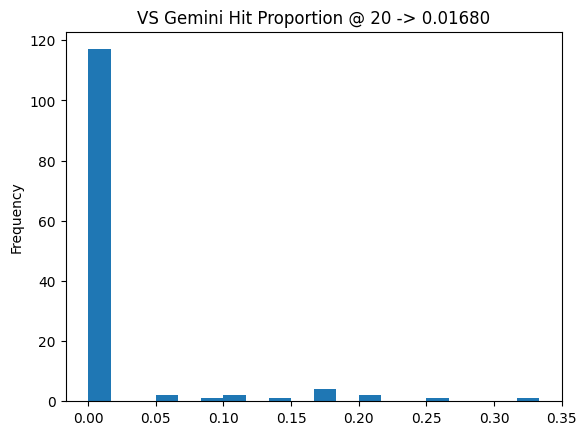

In [9]:
df_matches_vs = matches_vs.groupby('user_id', as_index=False).agg({
    'rec_gt': 'first', 
    'recipe_id': list,
    'recipe_profile_text': list,
    'title': list,
    'user_profile_text': 'first',   # or unique
    'n_history': 'first'
})
df_matches_vs['rec_gt'] = df_matches_vs['rec_gt'].apply(lambda x: [v for v in x if v not in excluded_recipes])
df_matches_vs['hit_count'] = df_matches_vs.apply(lambda row: sum(1 for r in row['rec_gt'] if r in row['recipe_id']), axis=1)
df_matches_vs['hit'] = df_matches_vs['hit_count'] > 0
df_matches_vs['hit_proportion'] = df_matches_vs['hit_count'] / df_matches_vs['rec_gt'].apply(len)

avg_hit_prop = df_matches_vs['hit_proportion'].mean()
std_hit_prop = df_matches_vs['hit_proportion'].std()
print(f"GEMINI EMBEDDINGS {avg_hit_prop=:.2f} {std_hit_prop=:.2f}")

if PLOT:
    df_matches_vs['hit_proportion'].plot(kind='hist', bins=20, title=f'VS Gemini Hit Proportion @ {TOP_K} -> {avg_hit_prop:.5f}')
    plt.show()


We obtain a `0.01680` in our metric (`recall@20`), which can seem small at first glance. However, in other work such as the [H\&M](https://www.kaggle.com/code/julian3833/h-m-implicit-als-model-0-014) competition and the [LlamaRec](https://arxiv.org/pdf/2311.02089) paper, recommendation metrics are typically small, and gains often show up in the second or third decimal place. Our implementation shows that BigQuery AI with vector search can cut the build time for a recommender from weeks to hours.

With a stronger retrieval stage, no matter the algorithm or heuristic, we can use `AI.GENERATE` to re rank the candidates, following a strategy like [LlamaRec](https://arxiv.org/pdf/2311.02089). For more ideas, see advanced techniques in [LRU](https://arxiv.org/pdf/2310.02367) and [Generative Retrieval](https://papers.neurips.cc/paper_files/paper/2023/file/20dcab0f14046a5c6b02b61da9f13229-Paper-Conference.pdf).

This approach also fits a hybrid recommender that blends collaborative filtering with content based filtering. You can even feed the embeddings as features to a neural network. The use of embeddings opens up many possibilities and BigQuery AI makes it easy to experiment with them.

Next we compare the results to an ALS baseline.


## ALS

Traditional Rec Sys methods fail to determine why a recommendation is relevant to a user. For this notebook, we use ALS as a fast, scalable baseline to compare against our vector search approach. It delivers top-K rankings we can compare against our vector search results.

In [ ]:
import implicit
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, ndcg_at_k
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from scipy.sparse import coo_matrix

In [11]:
df_train_users = client.query_and_wait(f"""
SELECT {SUBSET_COLS} FROM `{TRAIN_INTERACTIONS}`
WHERE user_id IN (SELECT user_id FROM `{PROJECT_ID}.{USERS_PARSED}`)
""").to_dataframe()

df_valid_users = client.query_and_wait(f"""
SELECT {SUBSET_COLS} FROM `{VALID_INTERACTIONS}`
WHERE user_id IN (SELECT user_id FROM `{PROJECT_ID}.{USERS_PARSED}`)
""").to_dataframe()

user_ids = df_train_users['user_id'].astype('category')
recipe_ids = df_train_users['recipe_id'].astype('category')

user_map = dict(enumerate(user_ids.cat.categories))  # idx -> user_id
recipe_map = dict(enumerate(recipe_ids.cat.categories))  # idx -> recipe_id

rows = user_ids.cat.codes.values
cols = recipe_ids.cat.codes.values

data = df_train_users['rating'].astype(float).values

# Build sparse matrix: users x items
train_matrix = coo_matrix((data, (rows, cols)), shape=(len(user_map), len(recipe_map)))
print("[TRAIN] User-Item Matrix:", train_matrix.shape)
print("[TRAIN] Non-zero elements:", train_matrix.nnz)
print("[TRAIN] Non-zero proportion:", train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]))

als_model = implicit.als.AlternatingLeastSquares(
    factors=32,          # latent dims
    regularization=0.05, # L2 reg
    iterations=500,       # ALS steps
    alpha=2.0,          # confidence scaling
    calculate_training_loss=True,
    random_state=0
)

als_model.fit(train_matrix.T)

[TRAIN] User-Item Matrix: (131, 1575)
[TRAIN] Non-zero elements: 2730
[TRAIN] Non-zero proportion: 0.013231552162849873


/home/tenken/Desktop/kaggle-bigquery-hackaton-2025/venv11/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0016307830810546875 seconds
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

ALS avg_hit_prop_als=0.01 std_hit_prop_als=0.04


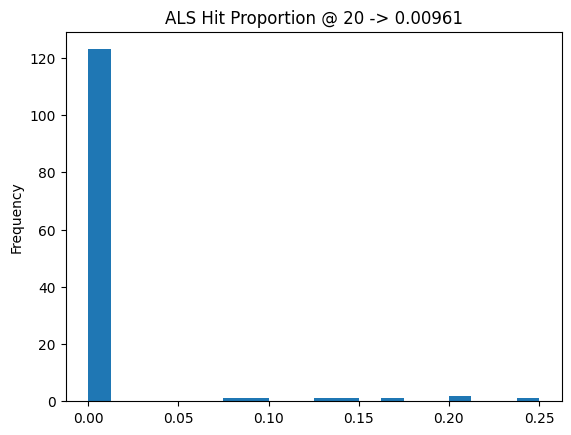

In [12]:
def get_recommendations(user_id: str, N: int = TOP_K, model = als_model):
    if user_id not in user_ids.cat.categories:
        raise ValueError(f"User ID {user_id} not found in training data.")
    
    user_idx = int(user_ids.cat.categories.get_loc(user_id))
    user_items = train_matrix.tocsr()[user_idx]
    
    recs = model.recommend(
        user_idx,
        user_items,
        N=N,
        filter_already_liked_items=True,
        recalculate_user=False
    )
    
    # recommended_recipes = [(recipe_map[i], score) for i, score in zip(*recs)]
    recommended_recipes = [recipe_map[r_i] for r_i, score in zip(*recs)]
    return recommended_recipes

df_matches_als = (
    df_valid_users.loc[lambda df: df['user_id'].isin(df_train_users['user_id'].values)]
    .groupby('user_id', as_index=False)
    .agg({'recipe_id': list})
).rename(columns={'recipe_id': 'rec_gt'})
df_matches_als['rec_gt'] = df_matches_als['rec_gt'].apply(lambda x: [v for v in x if v not in excluded_recipes])

df_matches_als['als_recommendations'] = df_matches_als['user_id'].apply(get_recommendations)
df_matches_als['hit_count'] = df_matches_als.apply(lambda row: sum(1 for r in row['rec_gt'] if r in row['als_recommendations']), axis=1)
df_matches_als['hit_proportion'] = df_matches_als['hit_count'] / df_matches_als['rec_gt'].apply(len)

avg_hit_prop_als = df_matches_als['hit_proportion'].mean()
std_hit_prop_als = df_matches_als['hit_proportion'].std()

print(f"ALS {avg_hit_prop_als=:.2f} {std_hit_prop_als=:.2f}")

if PLOT:
    df_matches_als['hit_proportion'].plot(kind='hist', bins=20, title=f'ALS Hit Proportion @ {TOP_K} -> {avg_hit_prop_als:.5f}')
    plt.show()


# LLM-as-a-Judge as middle ground between Offline Metrics and A/B Testing

Following the ideas of the [Spotify paper](https://dl.acm.org/doi/pdf/10.1145/3705328.3759305) accepted on RecSys'25 conference, we can use LLMs as offline judges to assess the quality of recommendations, in contrast to traditional offline metrics (e.g., recall@K) that suffer from exposure bias. This methodology could be considered as an intermediate step between offline metrics and online A/B testing, which is often costly and time-consuming, providing a more efficient way to evaluate and compare recommendation systems.

In [13]:
ALS_RECOMMENDATIONS_TABLE = f"{SCHEMA_NAME}.als_recommendations"
VS_RECOMMENDATIONS_TABLE = f"{SCHEMA_NAME}.vs_recommendations"
MODEL_COMPARISON_TABLE = f"{SCHEMA_NAME}.model_comparison"

We select a subset of users to be judged by the LLM, due to time inference and cost limitations.

In [16]:
users_to_judge = df_matches_vs.loc[lambda df : df['hit_proportion'] >= 0.1]['user_id'].values
print("Users to judge:", len(users_to_judge))

Users to judge: 11


As you will see, this experiment can be reproduced at scale using only BigQueryAI, with scheduled jobs or using more native tools and options that BigQuery offers.

But before, let's prepare the subset of recommendations to be evaluated.

In [17]:
# * Vector Search subset
vs_to_evaluate = matches_vs.loc[
    lambda df: df['user_id'].isin(users_to_judge)
][['user_id', 'recipe_id', 'user_profile_text', 'recipe_profile_text', 'title']].sort_values(by=['user_id'])

vs_to_evaluate.to_gbq(
    destination_table=f"{PROJECT_ID}.{VS_RECOMMENDATIONS_TABLE}",
    if_exists='replace',
)

/tmp/ipykernel_6322/1887638735.py:6: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  vs_to_evaluate.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


In [51]:
vs_to_evaluate.head(5)

,user_id,recipe_id,user_profile_text,recipe_profile_text,title
1978,1153011,11786,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian"",\n ""dietary_pr...",Hearty Vegetable Lasagna
1962,1153011,11815,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian American"",\n ""d...",Penne with Spicy Vodka Tomato Cream Sauce
1963,1153011,218794,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian"",\n ""dietary_pr...",Chicken and Gnocchi Soup
1964,1153011,21013,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian"",\n ""dietary_pr...",Sweet Potato Minestrone
1965,1153011,165350,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian-American"",\n ""d...",Baked Ziti with Sausage


In [18]:
# * ALS subset
als_to_evaluate = df_matches_als.loc[
    lambda df: df['user_id'].isin(users_to_judge)
][['user_id', 'als_recommendations', 'hit_proportion']]


print(f"Hit Proportion in ALS subset: {als_to_evaluate['hit_proportion'].mean():.2f}")
als_to_evaluate = als_to_evaluate.drop(columns=['hit_proportion']).explode('als_recommendations').rename(columns={'als_recommendations': 'recipe_id'})

als_to_evaluate = (
    als_to_evaluate.reset_index(drop=True).merge(
        vs_to_evaluate[['user_id', 'user_profile_text']].drop_duplicates(keep='first'),
        how='left',
        on=['user_id']
    )
)

recipe_ids_str = "(" + ",".join([f"'{rid}'" for rid in als_to_evaluate['recipe_id'].unique()]) + ")"
recipes_to_join = client.query_and_wait(f"""
SELECT recipe_id, recipe_profile_text, title FROM `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
WHERE recipe_id IN {recipe_ids_str}
""").to_dataframe()

als_to_evaluate = (
    als_to_evaluate.merge(
        recipes_to_join,
        how='left',
        on=['recipe_id']
    )
).sort_values(by=['user_id'])

als_to_evaluate.to_gbq(
    destination_table=f"{PROJECT_ID}.{ALS_RECOMMENDATIONS_TABLE}",
    if_exists='replace',
)

Hit Proportion in ALS subset: 0.00


/tmp/ipykernel_6322/1060322887.py:32: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  als_to_evaluate.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]


In [52]:
als_to_evaluate.head(5)

,user_id,recipe_id,user_profile_text,recipe_profile_text,title
0,1153011,12074,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian"",\n ""dietary_pr...",Pasta e Olio
19,1153011,10759,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""American"",\n ""dietary_p...",Oatmeal Peanut Butter Cookies III
18,1153011,127491,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""American"",\n ""dietary_p...",Easy OREO Truffles
17,1153011,12733,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""American"",\n ""dietary_p...",Crab Quiche I
16,1153011,104806,"{\n ""convenience_preference"": ""prefers practi...","{\n ""cuisine_type"": ""Italian"",\n ""dietary_pr...",Tomato and Mozzarella Bites


We implement the two complementary evaluation modes of the [paper](https://dl.acm.org/doi/pdf/10.1145/3705328.3759305):
- **Pointwise:** The LLM judges the relevance of each recommendation independently.
- **Pairwise:** The LLM compares two recommendation lists and selects the one it judges overall better, letting us choose the top model by its criteria.

## Pointwise LLM Judgement

As in the previous sections, we define the `Pydantic` model, the prompt and the SQL query to execute the pointwise judgement. In this setting, we choose `gemini-2.5-pro`, as the best model, it could offer more reliable responses in comparison to its smaller counterparts. We also set a limit of tokens to `4096` and a temperature of `0.0` to get more deterministic responses.

In [38]:
class PointwiseJudgement(BaseModel):
    would_like: bool = Field(description="True if the user would likely enjoy the recipe, False otherwise")
    confidence: str = Field(description="Confidence level in the judgement (e.g., high, medium, low)")
    justification: str = Field(description="Brief explanation of why the recipe is likely to be liked or not based on the user s profile and preferences")


pointwise_judgement_prompt = (
    "You are a strict impartial judge your task is to decide if the user would genuinely like the recipe based only on the user profile and the recipe profile "
    "default to would_like = False unless there is very strong and explicit evidence of clear alignment between user preferences and recipe characteristics "
    "be skeptical rigorous and never generous with positive judgements if the information is weak ambiguous or incomplete always output False "
    "always include would_like confidence and justification the justification must be concise factual and point out exact matches or mismatches between user and recipe "
    "do not use quotation marks commas periods semicolons or any other punctuation marks in your response only plain words "
    "format the response exactly as "
    f"{schema_to_prompt_with_descriptions(PointwiseJudgement)}"
)


pointwise_judgement_query = f"""
WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.title, 
    s.recipe_id, 
    s.user_profile_text, 
    s.recipe_profile_text,
    AI.GENERATE(('{pointwise_judgement_prompt}', s.user_profile_text, s.recipe_profile_text),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-pro',
        model_params => JSON '{{"generationConfig":{{"temperature": 0.0, "maxOutputTokens": 4096 }} }}',
        output_schema => 'would_like BOOL, confidence STRING, justification STRING'
    ) AS ai_result 
    FROM (SELECT * FROM `THE_TABLE`) s
)
SELECT
    *,
    ai_result.full_response AS pointwise_judgement,
    JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS pointwise_judgement_text
FROM ai_responses
"""

In [39]:
print(pointwise_judgement_prompt)

You are a strict impartial judge your task is to decide if the user would genuinely like the recipe based only on the user profile and the recipe profile default to would_like = False unless there is very strong and explicit evidence of clear alignment between user preferences and recipe characteristics be skeptical rigorous and never generous with positive judgements if the information is weak ambiguous or incomplete always output False always include would_like confidence and justification the justification must be concise factual and point out exact matches or mismatches between user and recipe do not use quotation marks commas periods semicolons or any other punctuation marks in your response only plain words format the response exactly as [  would_like (True if the user would likely enjoy the recipe, False otherwise)  confidence (Confidence level in the judgement (e.g., high, medium, low))  justification (Brief explanation of why the recipe is likely to be liked or not based on th

In [53]:
print(pointwise_judgement_query)


WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.title, 
    s.recipe_id, 
    s.user_profile_text, 
    s.recipe_profile_text,
    AI.GENERATE(('You are a strict impartial judge your task is to decide if the user would genuinely like the recipe based only on the user profile and the recipe profile default to would_like = False unless there is very strong and explicit evidence of clear alignment between user preferences and recipe characteristics be skeptical rigorous and never generous with positive judgements if the information is weak ambiguous or incomplete always output False always include would_like confidence and justification the justification must be concise factual and point out exact matches or mismatches between user and recipe do not use quotation marks commas periods semicolons or any other punctuation marks in your response only plain words format the response exactly as [  would_like (True if the user would likely enjoy the recipe, False otherwise)  confidence (

Run Pointwise Judgement for both sets of recommendations

In [40]:
vs_results = client.query_and_wait(pointwise_judgement_query.replace('THE_TABLE', VS_RECOMMENDATIONS_TABLE)).to_dataframe()
print(vs_results.iloc[0]['pointwise_judgement_text'])

vs_results['judge_veredict'] = vs_results['pointwise_judgement_text'].apply(lambda x: json.loads(x)['would_like'])

{
"confidence": "high",
"justification": "The recipe is American comfort food featuring bold savory and tangy flavors from beef and blue cheese which directly aligns with the user's preferences for American comfort food bold flavors and real cheese",
"would_like": true
}


In [41]:
als_results = client.query_and_wait(pointwise_judgement_query.replace('THE_TABLE', ALS_RECOMMENDATIONS_TABLE)).to_dataframe()
print(als_results.iloc[0]['pointwise_judgement_text'])

als_results['judge_veredict'] = als_results['pointwise_judgement_text'].apply(lambda x: json.loads(x)['would_like'])

{
"confidence": "high",
"justification": "user likes baked goods desserts and American comfort food which directly aligns with the recipe being an American dessert",
"would_like": true
}


In [42]:
# Update tables with the judge veredict
vs_results.to_gbq(
    destination_table=f"{PROJECT_ID}.{VS_RECOMMENDATIONS_TABLE}",
    if_exists='replace',
)

als_results.to_gbq(
    destination_table=f"{PROJECT_ID}.{ALS_RECOMMENDATIONS_TABLE}",
    if_exists='replace',
)

/tmp/ipykernel_6322/1245774309.py:2: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  vs_results.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 6492.73it/s]
/tmp/ipykernel_6322/1245774309.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  als_results.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 6472.69it/s]


After calculate the judgement for each recommendation individually, we can compute the average score for each model to determine which one performs better according to the LLM's criteria.

In [ ]:
def calculate_pointwise_metrics(vs_results: pd.DataFrame, als_results: pd.DataFrame) -> pd.DataFrame:
    lmbd_trnsform = lambda df: (
        df.groupby('user_id', as_index=False)
        .agg({'judge_veredict': 'sum', 'recipe_id': 'count'})
        .assign(llm_quality_score=lambda x: x['judge_veredict'] / x['recipe_id'])
    )
    df_join = lmbd_trnsform(vs_results).merge(
        lmbd_trnsform(als_results), on=['user_id'], suffixes=('_vs', '_als')
    )
    
    return df_join

df_metrics = calculate_pointwise_metrics(vs_results, als_results)
display(df_metrics)

,user_id,judge_veredict_vs,recipe_id_vs,llm_quality_score_vs,judge_veredict_als,recipe_id_als,llm_quality_score_als
0,1153011,16,20,0.800,14,20,0.700
1,1446852,4,20,0.200,4,20,0.200
2,2338929,18,20,0.900,10,20,0.500
3,2402648,20,20,1.000,17,20,0.850
4,2552683,19,20,0.950,19,20,0.950
5,3746251,20,20,1.000,6,20,0.300
6,4012560,16,20,0.800,10,20,0.500
7,4099655,15,20,0.750,11,20,0.550
8,4368963,16,20,0.800,3,20,0.150
9,484578,20,20,1.000,16,20,0.800


From the table, the LLM tends to favor the Vector Search model over the ALS baseline. This suggests the semantic information in the embeddings and vector search matches the LLM’s criteria better than a method (ALS) that only uses the user item interaction matrix. 

We can see a sample in the following cell, but it could be more easily explored in the UI we also prepared.

In [44]:
sample = vs_results.loc[lambda df: df['judge_veredict'] == False].reset_index(drop=True).iloc[0]

print(sample['user_profile_text'])
print(sample['recipe_profile_text'])
print(json.loads(sample['pointwise_judgement_text'])['justification'])

{
  "convenience_preference": "Open to moderate effort, prioritizes quality and flavor over extreme speed",
  "cuisine_preference": "American Comfort Food",
  "daypart_preferences": [
    "Savory breakfasts or brunch items",
    "Hearty and flavorful lunches",
    "Elaborate or comforting dinners",
    "Kid-friendly snacks"
  ],
  "dietary_preference": "No restrictions",
  "dietary_preferences": [
    "No processed ingredients",
    "Prefers fresh ingredients"
  ],
  "diversity_openness": "Selective",
  "flavor_preferences": [
    "Bold and savory",
    "Rich and creamy with real cheese",
    "Homemade sauces",
    "Spicy notes from fresh peppers or spices"
  ],
  "food_preferences": [
    "Comfort food",
    "Grilled meats",
    "Baked pasta dishes",
    "Customizable meals",
    "Homemade desserts with reduced sugar"
  ],
  "future_preferences": "This user may be interested in exploring regional American dishes with a focus on fresh, high-quality ingredients and traditional preparati

## Pairwise LLM Judgement

In this setting, we leverage the LLM's ability to compare two recommendation lists directly. The LLM will choose which list it finds more relevant for the user, providing a straightforward way to determine the superior recommendation method, in our case between Vector Search and ALS.

In [45]:
# In a setup analogous to A/B testing, the Judge compares two ranked episode lists, each from a different model, and select the one better aligned with the profile.

vs_to_judge = client.query_and_wait(f"""
SELECT * FROM `{PROJECT_ID}.{VS_RECOMMENDATIONS_TABLE}`
""").to_dataframe()
als_to_judge = client.query_and_wait(f"""
SELECT * FROM `{PROJECT_ID}.{ALS_RECOMMENDATIONS_TABLE}`
""").to_dataframe()

To ensure a fairer comparison, we randomize the order of the recommendation lists in the prompt so the LLM doesn’t favor the first or second list. This follows prior work aimed at reducing position bias.

In [46]:
def create_comparison_pairs(row: pd.Series):
    """This function create a part of the prompt to compare indistinctly two lists of recommendations originated from different models"""
    models_permutation = np.random.permutation(['als', 'vs']).tolist()

    sub_prompt = (
        f"USER PROFILE:\n{row['user_profile_text']}"
        "Compare the two lists of recommended recipes below and determine which list better aligns with the user's profile and preferences.\n\n"
    )

    for id_model, model in zip(["A", "B"], models_permutation):
        sub_prompt += f"""\n======================= BEGIN LIST of MODEL {id_model} =======================\n"""

        for idx, (title, recipe_profile) in enumerate(zip(row[f'title_{model}'], row[f'recipe_profile_text_{model}'])):
            sub_prompt += f""">>> Rank {idx}\n>>> Recipe Title: {title}\n>>> Recipe Profile: {recipe_profile}\n--------------------------------------------\n"""
        
        sub_prompt += "\n======================= END LIST =======================\n"

    return models_permutation, sub_prompt


pairwise_df = (
    vs_to_judge
    .groupby('user_id', as_index=False)
    .agg({'recipe_id': list, 'user_profile_text': 'first', 'title': list, 'recipe_profile_text': list})
    .merge(
        als_to_judge.groupby('user_id', as_index=False).agg({'recipe_id': list, 'title': list, 'recipe_profile_text': list}),
        on='user_id',
        suffixes=('_vs', '_als'),
        how='inner',
        validate='one_to_one'
    )
)
 
pairwise_df['models_permutation'], pairwise_df['comparison_prompt'] = zip(*pairwise_df.apply(create_comparison_pairs, axis=1))

print(pairwise_df['comparison_prompt'].iloc[0])

pairwise_df.to_gbq(
    destination_table=f"{PROJECT_ID}.{MODEL_COMPARISON_TABLE}",
    if_exists='replace',
)

USER PROFILE:
{
  "convenience_preference": "prefers practical yet adaptable recipes often making them more elaborate and flavorful than written",
  "cuisine_preference": "Italian-American and Southern/Cajun with an appreciation for Asian flavors when customized",
  "daypart_preferences": [
    "versatile dishes suitable for multiple meals",
    "hearty comfort foods for dinner",
    "baked goods for treats"
  ],
  "dietary_preference": "no specific restriction but sensitive to high spice levels and mindful of starch intake for general health",
  "dietary_preferences": [
    "low spice or mild flavor profiles",
    "occasional low starch modifications",
    "fresh ingredients preferred"
  ],
  "diversity_openness": "adventurous and open to trying new cuisines but will modify recipes to suit personal taste and dietary needs",
  "flavor_preferences": [
    "rich and creamy",
    "savory and umami",
    "subtle and balanced",
    "tangy and citrusy",
    "complex with fresh herbs and garl

/tmp/ipykernel_6322/3886247449.py:38: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  pairwise_df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8371.86it/s]


As in the `Pointwise` setting, we run `gemini-2.5-pro` with a 4096 token limit and a temperature of 0.0 to make the outputs more deterministic. Because the prompt is larger, we allocate 2048 thinking tokens to better use the model’s reasoning ability.

In [ ]:
class PairwiseJudgement(BaseModel):
    preferred_model: str = Field(description='Either "A" or "B", indicating which list of recommendations is better aligned with the user s profile')
    confidence: str = Field(description="Confidence level in the judgement (e.g., high, medium, low)")
    justification: str = Field(description="Brief explanation of why one list is preferred over the other based on alignment with the user s profile and preferences")


modelwise_judgement_prompt = (
    "You are a strict impartial judge your task is to decide which of the two lists of recommended recipes aligns better with the user s inferred preferences "
    "You need to choose between List A and List B, where each list contains a series of recipes recommended by different models "
    "You cannot choose both or neither you must pick the one that best matches the user s profile "
    "Base your decision solely on the information provided in the user profile and the recipe profiles in each list "
    f"Format the response exactly as {schema_to_prompt_with_descriptions(PairwiseJudgement)}"
)

query_pairwise_judgement = f"""
WITH ai_responses AS (
  SELECT 
    s.user_id,
    s.models_permutation,
    s.comparison_prompt,
    AI.GENERATE(('{modelwise_judgement_prompt}', s.comparison_prompt),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-pro',
        model_params => JSON '{{"generationConfig":{{"temperature": 0.0, "maxOutputTokens": 4096, "thinking_config": {{"thinking_budget": 2048}}  }} }}',
        output_schema => 'preferred_model STRING, confidence STRING, justification STRING'
    ) AS ai_result
    FROM (SELECT * FROM `{PROJECT_ID}.{MODEL_COMPARISON_TABLE}`) s
)
SELECT
    *,
    ai_result.full_response AS pairwise_judgement,
    JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS pairwise_judgement_text
FROM ai_responses
"""

In [54]:
print(modelwise_judgement_prompt)

You are a strict impartial judge your task is to decide which of the two lists of recommended recipes aligns better with the user s inferred preferences You need to choose between List A and List B, where each list contains a series of recipes recommended by different models You cannot choose both or neither you must pick the one that best matches the user s profile Base your decision solely on the information provided in the user profile and the recipe profiles in each list Format the response exactly as [  preferred_model (Either "A" or "B", indicating which list of recommendations is better aligned with the user s profile)  confidence (Confidence level in the judgement (e.g., high, medium, low))  justification (Brief explanation of why one list is preferred over the other based on alignment with the user s profile and preferences)  ]


In [55]:
print(query_pairwise_judgement)


WITH ai_responses AS (
  SELECT 
    s.user_id,
    s.models_permutation,
    s.comparison_prompt,
    AI.GENERATE(('You are a strict impartial judge your task is to decide which of the two lists of recommended recipes aligns better with the user s inferred preferences You need to choose between List A and List B, where each list contains a series of recipes recommended by different models You cannot choose both or neither you must pick the one that best matches the user s profile Base your decision solely on the information provided in the user profile and the recipe profiles in each list Format the response exactly as [  preferred_model (Either "A" or "B", indicating which list of recommendations is better aligned with the user s profile)  confidence (Confidence level in the judgement (e.g., high, medium, low))  justification (Brief explanation of why one list is preferred over the other based on alignment with the user s profile and preferences)  ]', s.comparison_prompt),
        c

We can see a sample result of the pairwise judgement in the following cell.

In [48]:
pairwise_results = client.query_and_wait(query_pairwise_judgement).to_dataframe()
pairwise_results['model_selected'] = pairwise_results.apply(
    lambda row: row['models_permutation'][0] if json.loads(row['pairwise_judgement_text'])['preferred_model'] == 'A' else row['models_permutation'][1],
    axis=1
)
print(pairwise_results.iloc[0]['pairwise_judgement_text'])

{
  "confidence": "high",
  "justification": "List A is an excellent match for the user's profile. It is dominated by Mexican, Tex-Mex, and Italian recipes, which are the user's top cuisine choices. The flavor profiles consistently feature 'spicy,' 'savory,' and 'tangy' elements, aligning perfectly with the user's preference for bold flavors. Furthermore, the list includes numerous soups, stews, and taco variations, and makes extensive use of the slow cooker, all of which are explicitly mentioned as preferences or lifestyle tags in the user profile. In contrast, List B is a very poor match, consisting mainly of sweet American desserts and mild, creamy main courses, which completely disregard the user's stated preferences for spicy, savory, and globally-inspired meals for lunch and dinner.",
  "preferred_model": "A"
}


The results can be examined in an administrator UI, where stakeholders review recommendations, their judgments, and user profiles to uncover patterns and insights that inform new business strategies.

In our shorter experiment, the LLM favored the Vector Search model in most cases, matching the pointwise findings and strengthening the claim that semantic embeddings produce more relevant recommendations than the ALS baseline in this setting. A larger study could deepen the analysis.


In [49]:
pairwise_results['model_selected'].value_counts()

model_selected
vs     10
als     1
Name: count, dtype: int64

In [ ]:
pairwise_results.to_gbq(
    destination_table=f"{PROJECT_ID}.{MODEL_COMPARISON_TABLE}",
    if_exists='replace',
)

/tmp/ipykernel_6322/962658920.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  pairwise_results.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 7096.96it/s]


# UI

We additionally develop a simple UI to facilitate the exploration of recommendations and their associated LLM-generated judgements. We based on the following user Stories 
## 🎯 User Stories

- **Discovering New Recipes**
    - *Necessity:* Browse a curated catalog of recipes to discover new dishes to try at home.
    - *Criteria:*
        - View recipe cards with images, ratings, and descriptions
        - Filter recipes by categories (Meat, Salads, Pasta, Soups, Desserts, Breakfasts)
        - See real user ratings from the community
        - Browse with intuitive category-based navigation

- **Smart Recipe Search**
    - *Necessity:* Search for recipes using natural language to quickly find desired dishes.
    - *Criteria:*
        - Search using semantic search powered by BigQuery ML embeddings
        - Get relevant results even with partial or descriptive queries
        - Fallback to text-based search if semantic search fails
        - Filter search results by category after searching

- **Visual Recipe Discovery**
    - *Necessity:* See appetizing images of recipes to better understand what to cook.
    - *Criteria:*
        - High-quality recipe images from Google Cloud Storage
        - Graceful fallback to placeholder images when photos aren't available
        - Consistent visual presentation across all recipe cards

- **Personalized Recommendations**
    - *Necessity:* Receive personalized recipe recommendations that match user taste profiles.
    - *Criteria:*
        - View AI-generated recommendations based on user profile
        - See explanations for why recipes were recommended
        - Access both approved and experimental recommendations
        - Recommendations adapt based on interaction history

- **Profile Management**
    - *Necessity:* View and manage food preferences for better recommendations.
    - *Criteria:*
        - View user profile with AI-analyzed preferences
        - See cuisine preferences, dietary restrictions, and lifestyle tags
        - Understand how preferences were determined from history

- **Recipe History Tracking**
    - *Necessity:* Track recipe history to remember past experiences and ratings.
    - *Criteria:*
        - View chronological list of recipes interacted with
        - See ratings and comments for each recipe
        - Understand cooking patterns over time

- **Recommendation Management**
    - *Necessity:* Manage and validate AI recommendations to ensure quality control.
    - *Criteria:*
        - Review AI-generated recommendations before they go live
        - Monitor recommendation system performance
        - Adjust recommendation algorithms based on user feedback

Following this User Stories, we develop the following arquitecture for the UI:

## 🏗️ Technical Architecture

### Frontend (Next.js 15.5.3)
- **React 19** with modern hooks and server components
- **Tailwind CSS 4** for responsive, modern UI design
- **Client-side routing** with Next.js App Router
- **Responsive design** with mobile-first approach

### Backend Integration
- **BigQuery ML** for semantic search and embeddings
- **Google Cloud Storage** for recipe image management
- **RESTful APIs** for data fetching and user interactions
- **Real-time search** with semantic and text-based fallbacks

### Data Sources
- **BigQuery Dataset:** `kaggle-bigquery-471522.foodrecsys`
  - `recipes` - Recipe details and user reviews
  - `recipe_profiles` - ML embeddings for semantic search
  - `vs_recommendations` - AI-generated recommendations
  - `user_profiles` - User preference analysis
  - `users_parsed` - User interaction history

## Blocks Diagram
<img src="image/Arquitecture_connections.svg" alt="UI Architecture Connections" width="500"/>

## API Flow
<img src="image/API_Flow.svg" alt="UI API Flow" width="500"/>

## Views of endpoints
### Catalogue
<img src="image/Catalogue.png" alt="Catalogue View" width="500"/>

Here we have the Search bar to realize the semantic search, also by default we show the recipes recommended by model without Verification of the Judge. Also implement a basic filter by the category of the Recipe.

### Profile
<img src="image/Profile.png" alt="Catalogue View" width="500"/>

In profile we show Important information of the user as Address, cellphone number and User profile key values as cuisine, food type, among others.

### Admin Recommendations
<img src="image/Admin_recommendations.png" alt="Catalogue View" width="500"/>

We show the recommendations for the specific user but giving the key value of the reason why the product is recommended to the user to evaluate if the model is recommended well based on user profile. 

### User Recommendations
<img src="image/User_recommendations.png" alt="Catalogue View" width="500"/>

Similar to admin recommendations, but differs in showing the user profile to the user understands why some recipes recommendations and the ingredients for each recipe,

### Recipe History
<img src="image/Recipe_History.png" alt="Catalogue View" width="500"/>

List all the recipes the user rate by the time, its comments, the date and the stars the user gives. 

# Summary and Conclusions

## Feedback on BigQuery AI features
- Passing Pydantic attribute descriptions as LLM schemas was difficult at first, so we wrote a helper that injects each field’s description into the prompt. A more direct mapping from Pydantic (including field names, data type, descriptions and constraints) to schemas would help. Pydantic is widely used in the Python ecosystem, including in popular libraries like LangChain and Instructor, so this would be a valuable enhancement.
- LLM calls were slow even with lightweight models, so we limited the number of recipes and users. Faster execution and built-in progress reporting would be valuable.
- When outputs exceed the token limit, quoting errors can appear. Clearer messages and partial-result handling would ease debugging and prevent entire queries from failing.
- Gemini Embedding 001 sometimes returns empty embeddings for certain inputs; the cause remains unclear.

## User Survey on BigQuery AI features

* `jeremy.matos@utec.edu.pe`
  * BigQuery AI experience: about 1 month (this competition)
  * Google Cloud experience: 3 months
  * I authored all feedback above, reflecting my hands-on work with BigQuery AI in this project.
* `luis.gutierrez.g@utec.edu.pe`
  * BigQuery AI experience: 1 month (API connector, semantic search, embeddings)
  * Google Cloud experience: 1 months (IAM, BigQuery, GCS integration)
  * I designed and implemented the web UI, semantic search, and integrated BigQuery AI embeddings for personalized recommendations in this project. My feedback is based on building the end-to-end user-facing application and connecting it to BigQuery AI services.

Thank you for taking the time to read our submission! I hope you found it interesting and useful. If you have any questions, feedback or are experiencing technical issues evaluating this notebook, please do not hesitate to contact us.